## Record Linkage

In [1]:
import pandas as pd
df = pd.read_excel(r'C:\Users\GauravS15\Documents\Record Linkage 2.0\Dataset\EHR_Dataset.xlsx')


In [4]:
import cryptpandas as crp
crp.to_encrypted(df, password='mypassword123', path='file.crypt')

In [5]:
from cryptography.fernet import Fernet

key = Fernet.generate_key()
crypter = Fernet(key)

pw = crypter.encrypt(b'Password')

print(pw)

b'gAAAAABkSgIu75PfooBZUqTeruKrU6fc7XPTJdWlDQztBOT2SKMKqFlgbRpeKzmtJ9ae9lrSFUU5DSXloArJWMm8RdkqjdOlmA=='


In [505]:
import recordlinkage
from recordlinkage.datasets import load_febrl3

In [506]:
dfA,links = load_febrl3(return_links=True)
# dfA.to_excel('Febrl_Data.xlsx')

In [507]:
dfA.columns

Index(['given_name', 'surname', 'street_number', 'address_1', 'address_2',
       'suburb', 'postcode', 'state', 'date_of_birth', 'soc_sec_id'],
      dtype='object')

In [508]:
len(dfA)

5000

In [509]:
import recordlinkage
from recordlinkage.index import SortedNeighbourhood

In [510]:
from recordlinkage.index import Block
Block_Index_by_State = Block("state")
Block_Index_by_State_Pairs = Block_Index_by_State.index(dfA)

In [511]:
indexer = SortedNeighbourhood('surname', window = 5)
candidate_links = indexer.index(dfA)

In [512]:
All_Index_Pairs = Block_Index_by_State_Pairs.append(candidate_links)
#Remove duplicate Pairs 
All_Index_Pairs = All_Index_Pairs.drop_duplicates(keep='first')

In [513]:
compare_cl = recordlinkage.Compare()

compare_cl.string("given_name", "given_name", method="jarowinkler", threshold=0.75, label="given_name")
compare_cl.string("surname", "surname", method="jarowinkler", threshold=0.75, label="surname")
compare_cl.exact("date_of_birth", "date_of_birth", label="date_of_birth")
compare_cl.string("suburb", "suburb", method="jarowinkler", threshold=0.75, label="suburb")
compare_cl.string("state", "state", method="jarowinkler",threshold=0.75, label="state")
compare_cl.string("address_1", "address_1", method="jarowinkler",threshold=0.75, label="address_1")
compare_cl.string("address_2", "address_2", method="jarowinkler",threshold=0.75, label="address_2")

feature_vector = compare_cl.compute(All_Index_Pairs, dfA)

In [514]:
len(feature_vector)

2607630

### Classification

In [515]:
import numpy as np

In [516]:
duplicate_pairs_vectors = compare_cl.compute(links,dfA)

In [517]:
duplicate_pairs_vectors.reset_index()

,level_0,level_1,given_name,surname,date_of_birth,suburb,state,address_1,address_2
0,rec-552-dup-1,rec-552-dup-3,1.0,1.0,1,1.0,1.0,1.0,1.0
1,rec-552-dup-0,rec-552-dup-3,1.0,1.0,1,1.0,1.0,1.0,1.0
2,rec-552-dup-0,rec-552-dup-1,1.0,1.0,1,1.0,1.0,1.0,1.0
3,rec-552-org,rec-552-dup-3,1.0,1.0,1,1.0,1.0,1.0,1.0
4,rec-552-org,rec-552-dup-1,1.0,1.0,1,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
6533,rec-521-org,rec-521-dup-0,1.0,1.0,1,1.0,1.0,1.0,1.0
6534,rec-939-dup-0,rec-939-org,1.0,1.0,1,1.0,1.0,0.0,0.0
6535,rec-1956-dup-0,rec-1956-org,1.0,1.0,1,1.0,1.0,1.0,1.0
6536,rec-214-org,rec-214-dup-0,1.0,1.0,1,1.0,1.0,1.0,1.0


In [518]:
duplicate_pairs = duplicate_pairs_vectors.reset_index()
duplicate_pairs_1 = duplicate_pairs["level_0"]+','+duplicate_pairs["level_1"]
duplicate_pairs_2 = duplicate_pairs["level_1"]+','+duplicate_pairs["level_0"]
final_duplicate_pairs = pd.DataFrame(duplicate_pairs_1.append(duplicate_pairs_2))

C:\Users\GauravS15\AppData\Local\Temp\ipykernel_25988\2091847370.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_duplicate_pairs = pd.DataFrame(duplicate_pairs_1.append(duplicate_pairs_2))


In [519]:
final_duplicate_pairs

,0
0,"rec-552-dup-1,rec-552-dup-3"
1,"rec-552-dup-0,rec-552-dup-3"
2,"rec-552-dup-0,rec-552-dup-1"
3,"rec-552-org,rec-552-dup-3"
4,"rec-552-org,rec-552-dup-1"
...,...
6533,"rec-521-dup-0,rec-521-org"
6534,"rec-939-org,rec-939-dup-0"
6535,"rec-1956-org,rec-1956-dup-0"
6536,"rec-214-dup-0,rec-214-org"


In [520]:
duplicate_pairs = duplicate_pairs_vectors.reset_index()
duplicate_pairs_1 = duplicate_pairs["level_0"]+','+duplicate_pairs["level_1"]
duplicate_pairs_2 = duplicate_pairs["level_1"]+','+duplicate_pairs["level_0"]
final_duplicate_pairs = pd.DataFrame(duplicate_pairs_1.append(duplicate_pairs_2))
comparison_pairs = feature_vector.reset_index()
comparison_pairs['join_keys'] = comparison_pairs["rec_id_1"]+','+comparison_pairs["rec_id_2"]
# 1 represent Duplicates, 0 represent non duplicates
comparison_pairs['Label'] = np.where(comparison_pairs["join_keys"].isin(final_duplicate_pairs[0]), 1, 0)
comparison_pairs.groupby(['Label'])['join_keys'].count()

C:\Users\GauravS15\AppData\Local\Temp\ipykernel_25988\279989275.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_duplicate_pairs = pd.DataFrame(duplicate_pairs_1.append(duplicate_pairs_2))


Label
0    2601232
1       6398
Name: join_keys, dtype: int64

In [521]:
len(comparison_pairs)

2607630

In [522]:
comparison_pairs[comparison_pairs['Label']==1]

,rec_id_1,rec_id_2,given_name,surname,date_of_birth,suburb,state,address_1,address_2,join_keys,Label
19,rec-1062-dup-3,rec-1062-dup-1,0.0,1.0,0,0.0,1.0,0.0,1.0,"rec-1062-dup-3,rec-1062-dup-1",1
218,rec-108-dup-1,rec-108-org,1.0,1.0,1,1.0,1.0,1.0,1.0,"rec-108-dup-1,rec-108-org",1
490,rec-1581-dup-0,rec-1581-dup-1,1.0,1.0,1,0.0,1.0,0.0,0.0,"rec-1581-dup-0,rec-1581-dup-1",1
557,rec-584-dup-3,rec-584-dup-1,0.0,1.0,1,1.0,1.0,1.0,0.0,"rec-584-dup-3,rec-584-dup-1",1
856,rec-957-dup-0,rec-957-org,1.0,1.0,1,1.0,1.0,1.0,1.0,"rec-957-dup-0,rec-957-org",1
...,...,...,...,...,...,...,...,...,...,...,...
2607199,rec-35-dup-1,rec-35-dup-2,1.0,1.0,0,1.0,0.0,0.0,1.0,"rec-35-dup-1,rec-35-dup-2",1
2607370,rec-772-dup-3,rec-772-org,1.0,1.0,1,1.0,0.0,1.0,1.0,"rec-772-dup-3,rec-772-org",1
2607373,rec-772-dup-3,rec-772-dup-1,1.0,1.0,1,1.0,0.0,1.0,1.0,"rec-772-dup-3,rec-772-dup-1",1
2607377,rec-772-dup-3,rec-772-dup-0,1.0,1.0,1,1.0,0.0,1.0,1.0,"rec-772-dup-3,rec-772-dup-0",1


In [523]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

#Index Composite Variables
Model_Data_Set = comparison_pairs.set_index(['join_keys','rec_id_1','rec_id_2'])

#Split Data Into Label and Features
y = Model_Data_Set['Label']
x = Model_Data_Set.drop(['Label'],axis=1)

#Create Training & Test Set 
seed = 10
test_size = 0.1
x_train, x_test, y_train, y_test = model_selection.train_test_split(x,y,test_size=test_size, random_state=seed, stratify=y)

pd.Series(y_test).value_counts()

0    260123
1       640
Name: Label, dtype: int64

In [524]:
model= xgb.XGBClassifier(learning_rate = 0.01, n_estimators=300, max_depth=5)
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [525]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [526]:
import pickle

pickle.dump(model,open('model_ver1.sav','wb'))

In [527]:
model = pickle.load(open('model_ver1.sav','rb'))

In [528]:
pred = model.predict(x_test)
y_pred = pd.DataFrame(pred)
predictions = y_pred
predictions['predict'] = y_pred

In [529]:
dfcombine = pd.merge(x_test.reset_index(),predictions[['predict']],how='left',left_index= True, right_index = True)
dfcombine[dfcombine['predict']==1]

,join_keys,rec_id_1,rec_id_2,given_name,surname,date_of_birth,suburb,state,address_1,address_2,predict
596,"rec-121-org,rec-121-dup-1",rec-121-org,rec-121-dup-1,1.0,1.0,1,1.0,1.0,1.0,1.0,1
1298,"rec-1007-dup-3,rec-1007-dup-2",rec-1007-dup-3,rec-1007-dup-2,1.0,1.0,1,1.0,1.0,0.0,1.0,1
2084,"rec-1035-org,rec-1035-dup-0",rec-1035-org,rec-1035-dup-0,1.0,1.0,1,1.0,1.0,0.0,0.0,1
2211,"rec-954-dup-1,rec-954-dup-4",rec-954-dup-1,rec-954-dup-4,1.0,1.0,1,0.0,1.0,1.0,0.0,1
2287,"rec-46-dup-0,rec-46-dup-2",rec-46-dup-0,rec-46-dup-2,1.0,1.0,1,1.0,1.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
259514,"rec-919-dup-0,rec-919-org",rec-919-dup-0,rec-919-org,1.0,1.0,0,1.0,1.0,0.0,0.0,1
259554,"rec-1684-dup-3,rec-1684-dup-4",rec-1684-dup-3,rec-1684-dup-4,1.0,1.0,1,1.0,1.0,1.0,0.0,1
259703,"rec-1109-dup-0,rec-1109-dup-1",rec-1109-dup-0,rec-1109-dup-1,1.0,1.0,1,1.0,1.0,1.0,1.0,1
260159,"rec-1103-org,rec-1103-dup-3",rec-1103-org,rec-1103-dup-3,1.0,1.0,1,1.0,1.0,1.0,1.0,1


In [530]:
accuracy_score(y_test,pred)

0.9999616510011006

In [531]:
confusion_matrix(y_test, pred)

array([[260122,      1],
       [     9,    631]], dtype=int64)

In [532]:
len(x_train)

2346867

Considering Febrl Dataset:

The total number of records: 1000

The pairwise combinations of records generated:117963

Training Records: 2346867, Testing Records: 260763

Accuracy Score Observed: 0.9999616510011006

Confusion Matrix:


C:\Users\GauravS15\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


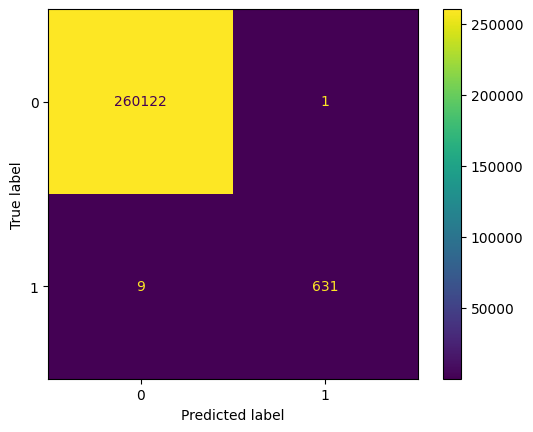

In [535]:
import matplotlib.pyplot as plt 
from sklearn.metrics import plot_confusion_matrix

print("Considering Febrl Dataset:")

print()

print(f"The total number of records: 1000")

print()

print(f"The pairwise combinations of records generated:117963")

print()

print(f'Training Records: {len(x_train)}, Testing Records: {len(x_test)}')

print()

print("Accuracy Score Observed:", accuracy_score(y_test,pred))

print()

print("Confusion Matrix:")

plot_confusion_matrix(model ,x_test, y_test)  
plt.show()  

report = classification_report(y_test, pred, output_dict = True)

df = pd.DataFrame(report).transpose()

df.to_excel('Report.xlsx')


### Testing

In [373]:
import recordlinkage
from recordlinkage.datasets import load_febrl1

In [375]:
dfA = dfA

In [376]:
dfA.columns

Index(['rec_id', 'given_name', 'surname', 'street_number', 'address_1',
       'address_2', 'suburb', 'postcode', 'state', 'date_of_birth',
       'soc_sec_id'],
      dtype='object')

In [377]:
import recordlinkage
from recordlinkage.index import SortedNeighbourhood

In [378]:
from recordlinkage.index import Block
Block_Index_by_State = Block("state")
Block_Index_by_State_Pairs = Block_Index_by_State.index(dfA)

In [379]:
indexer = SortedNeighbourhood('surname', window = 5)
candidate_links = indexer.index(dfA)

In [380]:
All_Index_Pairs = Block_Index_by_State_Pairs.append(candidate_links)
All_Index_Pairs = All_Index_Pairs.drop_duplicates(keep='first')

In [381]:
compare_cl = recordlinkage.Compare()

compare_cl.string("given_name", "given_name", method="jarowinkler", threshold=0.75, label="given_name")
compare_cl.string("surname", "surname", method="jarowinkler", threshold=0.75, label="surname")
compare_cl.exact("date_of_birth", "date_of_birth", label="date_of_birth")
compare_cl.string("suburb", "suburb", method="jarowinkler", threshold=0.75, label="suburb")
compare_cl.string("state", "state", method="jarowinkler",threshold=0.75, label="state")
compare_cl.string("address_1", "address_1", method="jarowinkler",threshold=0.75, label="address_1")
compare_cl.string("address_2", "address_2", method="jarowinkler",threshold=0.75, label="address_2")

feature_vector = compare_cl.compute(All_Index_Pairs, dfA)

In [382]:
len(feature_vector)

117963

In [383]:
comparison_pairs = feature_vector.reset_index()
comparison_pairs

,level_0,level_1,given_name,surname,date_of_birth,suburb,state,address_1,address_2
0,5,0,0.0,0.0,0,0.0,1.0,0.0,0.0
1,25,0,0.0,0.0,0,0.0,1.0,1.0,0.0
2,25,5,0.0,0.0,0,0.0,1.0,0.0,0.0
3,58,0,0.0,0.0,0,0.0,1.0,0.0,0.0
4,58,5,0.0,0.0,0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
117958,967,578,0.0,0.0,0,0.0,0.0,0.0,0.0
117959,986,47,0.0,0.0,0,0.0,0.0,0.0,0.0
117960,986,673,0.0,0.0,0,0.0,0.0,0.0,0.0
117961,995,52,0.0,0.0,0,0.0,0.0,0.0,0.0


In [347]:
comparison_pairs = feature_vector.reset_index()
comparison_pairs['join_keys'] = comparison_pairs["level_0"]+','+comparison_pairs["level_1"]

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('int64'), dtype('<U1')) -> None

In [329]:
comparison_pairs

,level_0,level_1,given_name,surname,date_of_birth,suburb,state,address_1,address_2
0,5,0,0.0,0.0,0,0.0,1.0,0.0,0.0
1,25,0,0.0,0.0,0,0.0,1.0,1.0,0.0
2,25,5,0.0,0.0,0,0.0,1.0,0.0,0.0
3,58,0,0.0,0.0,0,0.0,1.0,0.0,0.0
4,58,5,0.0,0.0,0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
117958,967,578,0.0,0.0,0,0.0,0.0,0.0,0.0
117959,986,47,0.0,0.0,0,0.0,0.0,0.0,0.0
117960,986,673,0.0,0.0,0,0.0,0.0,0.0,0.0
117961,995,52,0.0,0.0,0,0.0,0.0,0.0,0.0


In [214]:
Dataset = comparison_pairs.set_index(['join_keys','rec_id_1','rec_id_2'])

In [237]:
dfA = dfA.reset_index()
dfA

,index,rec_id,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
0,0,rec-223-org,NaN,waller,6,tullaroop street,willaroo,st james,4011,wa,19081209,6988048
1,1,rec-122-org,lachlan,berry,69,giblin street,killarney,bittern,4814,qld,19990219,7364009
2,2,rec-373-org,deakin,sondergeld,48,goldfinch circuit,kooltuo,canterbury,2776,vic,19600210,2635962
3,3,rec-10-dup-0,kayla,harrington,NaN,maltby circuit,coaling,coolaroo,3465,nsw,19150612,9004242
4,4,rec-227-org,luke,purdon,23,ramsay place,mirani,garbutt,2260,vic,19831024,8099933
...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,rec-188-dup-0,stephanie,geu,28,bainton crescent,masonic memorial village,maryborough,2541,sa,19421008,3997529
996,996,rec-334-dup-0,nicholas,NaN,289,britten-jonues drive,jabaru court,paddington,2000,vic,19970422,5062738
997,997,rec-469-dup-0,lachlan,katsiavos,29,paul coe cdrescent,NaN,casual,2913,nsw,19380406,4112327
998,998,rec-350-dup-0,monique,gergely,21,harwoos court,hyberni a park,sherwood,2207,nsw,19790807,7375144


In [218]:
y_pred = pd.DataFrame(model.predict(Dataset))
predictions = y_pred
predictions['predict'] = y_pred

In [219]:
predictions

,0,predict
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
117958,0,0
117959,0,0
117960,0,0
117961,0,0


In [222]:
dfcombine = pd.merge(Dataset.reset_index(),predictions[['predict']],how='left',left_index= True, right_index = True)
new_df = dfcombine[dfcombine['predict']==1]

In [238]:
new_df

,join_keys,rec_id_1,rec_id_2,given_name,surname,date_of_birth,suburb,state,address_1,address_2,predict
42,"rec-333-org,rec-333-dup-0",rec-333-org,rec-333-dup-0,1.0,0.0,1,1.0,1.0,1.0,1.0,1
117,"rec-471-dup-0,rec-471-org",rec-471-dup-0,rec-471-org,1.0,1.0,1,1.0,1.0,1.0,0.0,1
214,"rec-490-org,rec-490-dup-0",rec-490-org,rec-490-dup-0,0.0,1.0,0,1.0,1.0,1.0,0.0,1
263,"rec-26-org,rec-26-dup-0",rec-26-org,rec-26-dup-0,0.0,1.0,1,1.0,1.0,1.0,0.0,1
317,"rec-245-dup-0,rec-245-org",rec-245-dup-0,rec-245-org,1.0,0.0,0,1.0,1.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
116541,"rec-315-org,rec-315-dup-0",rec-315-org,rec-315-dup-0,1.0,1.0,1,1.0,0.0,1.0,1.0,1
116544,"rec-341-org,rec-341-dup-0",rec-341-org,rec-341-dup-0,1.0,1.0,1,1.0,0.0,0.0,1.0,1
116548,"rec-494-org,rec-494-dup-0",rec-494-org,rec-494-dup-0,1.0,1.0,1,1.0,1.0,1.0,1.0,1
116549,"rec-430-dup-0,rec-430-org",rec-430-dup-0,rec-430-org,1.0,1.0,1,1.0,0.0,1.0,1.0,1


In [264]:
df3 = pd.DataFrame([['1','2',3],['2','4','5'],['3','6','7']],columns = ['t','u','v'])
df3

,t,u,v
0,1,2,3
1,2,4,5
2,3,6,7


In [273]:
df = []
for ind in new_df.index:

    rec1 = new_df['rec_id_1'][ind]
    rec2 = new_df['rec_id_2'][ind]

    row1 = dfA.loc[dfA['rec_id']==rec1]
    row2 = dfA.loc[dfA['rec_id']==rec2]
    given_name
    df.append([rec1,rec2,row1['given_name'],row2['given_name'],row1['surname'],row2['surname']])

In [272]:
df = pd.DataFrame(df,columns = ['Record-1','Record-2','FirstName(1)','FirstName(2)','Surname(1)','Surname(2)'])
df

,Record-1,Record-2,FirstName(1),FirstName(2),Surname(1),Surname(2)
0,rec-333-org,rec-333-dup-0,"159 thomas Name: given_name, dtype: object","96 thomas Name: given_name, dtype: object","159 shepherd Name: surname, dtype: object","96 graue Name: surname, dtype: object"
1,rec-471-dup-0,rec-471-org,"232 barnaby Name: given_name, dtype: object","182 barnaby Name: given_name, dtype: object","232 shereston Name: surname, dtype: object","182 shereston Name: surname, dtype: object"
2,rec-490-org,rec-490-dup-0,"294 NaN Name: given_name, dtype: object","74 NaN Name: given_name, dtype: object","294 durr Name: surname, dtype: object","74 durr Name: surname, dtype: object"
3,rec-26-org,rec-26-dup-0,"322 abbey Name: given_name, dtype: object","160 NaN Name: given_name, dtype: object","322 hoffman Name: surname, dtype: object","160 hoffman Name: surname, dtype: object"
4,rec-245-dup-0,rec-245-org,"332 riley Name: given_name, dtype: object","250 riley Name: given_name, dtype: object","332 h o Name: surname, dtype: object","250 ho Name: surname, dtype: object"
...,...,...,...,...,...,...
484,rec-315-org,rec-315-dup-0,"568 takeisha Name: given_name, dtype: object","563 takeisha Name: given_name, dtype: object","568 smallacombe Name: surname, dtype: object","563 smallacombe Name: surname, dtype: object"
485,rec-341-org,rec-341-dup-0,"762 emiily Name: given_name, dtype: object","689 emiily Name: given_name, dtype: object","762 george Name: surname, dtype: object","689 george Name: surname, dtype: object"
486,rec-494-org,rec-494-dup-0,"890 chelsea Name: given_name, dtype: object","672 chelsae Name: given_name, dtype: object","890 hanigan Name: surname, dtype: object","672 hanigan Name: surname, dtype: object"
487,rec-430-dup-0,rec-430-org,"881 bejnamin Name: given_name, dtype: object","800 benjamin Name: given_name, dtype: object","881 liapis Name: surname, dtype: object","800 liapis Name: surname, dtype: object"


### Extra

In [59]:
len(features)

6846

In [60]:
features

given_name  surname  date_of_birth  suburb  \
rec_id_1      rec_id_2                                                    
rec-469-dup-0 rec-277-dup-0         0.0      0.0              0     0.0   
rec-342-org   rec-96-dup-0          0.0      0.0              0     0.0   
              rec-96-org            0.0      0.0              0     0.0   
              rec-189-dup-0         0.0      0.0              0     0.0   
rec-342-dup-0 rec-96-dup-0          0.0      0.0              0     0.0   
...                                 ...      ...            ...     ...   
rec-99-dup-0  rec-135-dup-0         0.0      0.0              0     0.0   
              rec-135-org           0.0      0.0              0     0.0   
rec-309-org   rec-322-org           0.0      0.0              0     0.0   
rec-491-dup-0 rec-309-org           1.0      0.0              0     0.0   
rec-416-dup-0 rec-476-dup-0         0.0      0.0              0     0.0   

                             state  address_1  address_2  
rec_id_1      rec_id_2                                    
rec-469-dup-0 rec-277-dup-0    1.0        0.0        0.0  
rec-342-org   rec-96-dup-0     0.0        0.0        0.0  
              rec-96-org       0.0        0.0        0.0  
              rec-189-dup-0    0.0        0.0        0.0  
rec-342-dup-0 rec-96-dup-0     0.0        0.0        0.0  
...                            ...        ...        ...  
rec-99-dup-0  rec-135-dup-0    0.0        0.0        0.0  
              rec-135-org      0.0        0.0        0.0  
rec-309-org   rec-322-org      1.0        0.0        0.0  
rec-491-dup-0 rec-309-org      0.0        0.0        0.0  
rec-416-dup-0 rec-476-dup-0    1.0        0.0        0.0  

[6846 rows x 7 columns]

In [47]:
recordlinkage.confusion_matrix(Links, features, total=None)

array([[ 372.,  128.],
       [6474.,   nan]])

In [61]:
import numpy as np

matches = features[features.sum(axis=1) > 4]
scores = np.average(matches.values, axis=1)

In [63]:
len(matches)

362

In [30]:
matches = matches.assign(score=scores)

In [31]:
matches.columns

Index(['given_name', 'surname', 'date_of_birth', 'suburb', 'state',
       'address_1', 'address_2', 'score'],
      dtype='object')

In [32]:
matches_df = pd.DataFrame(matches)

In [33]:
matches_df[["given_name","surname","date_of_birth"]]

,,given_name,surname,date_of_birth
rec_id_1,rec_id_2,,,
rec-439-dup-0,rec-439-org,1.0,1.0,1
rec-71-org,rec-71-dup-0,1.0,1.0,1
rec-423-dup-0,rec-423-org,1.0,1.0,1
rec-430-dup-0,rec-430-org,1.0,1.0,1
rec-176-dup-0,rec-176-org,1.0,1.0,1
...,...,...,...,...
rec-222-dup-0,rec-222-org,1.0,1.0,1
rec-368-org,rec-368-dup-0,1.0,1.0,1
rec-99-dup-0,rec-99-org,1.0,1.0,0


In [17]:
col = matches_df.columns
matches_df[col[5:]]

,,address_1,address_2,score
338,20,1.0,0.0,0.857143
489,234,1.0,1.0,1.000000
766,432,1.0,1.0,1.000000
881,800,1.0,1.0,0.857143
894,460,1.0,1.0,0.857143
...,...,...,...,...
943,942,1.0,1.0,1.000000
962,714,1.0,1.0,1.000000
983,57,1.0,1.0,0.857143
583,310,1.0,1.0,1.000000


In [192]:
matches

,,given_name,surname,date_of_birth,suburb,state,address_1,address_2,score
766,432,1.0,1.0,1,1.0,1.0,1.0,1.0,1.000000
881,800,1.0,1.0,1,1.0,0.0,1.0,1.0,0.857143
894,460,1.0,1.0,1,0.0,1.0,1.0,1.0,0.857143
952,192,1.0,1.0,1,0.0,1.0,1.0,1.0,0.857143
405,220,1.0,1.0,1,1.0,1.0,0.0,0.0,0.714286
...,...,...,...,...,...,...,...,...,...
943,942,1.0,1.0,1,1.0,1.0,1.0,1.0,1.000000
962,714,1.0,1.0,1,1.0,1.0,1.0,1.0,1.000000
983,57,1.0,1.0,0,1.0,1.0,1.0,1.0,0.857143
583,310,1.0,1.0,1,1.0,1.0,1.0,1.0,1.000000


In [228]:
print(dfA.iloc[matches.index.get_level_values(0)[1],4])
print(dfA.iloc[matches.index.get_level_values(1)[1],5])
print(list(matches['score']))

stacy street
st francis vlge
[0.8571428571428571, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 1.0, 1.0, 0.7142857142857143, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.7142857142857143, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 1.0, 0.85714285

In [233]:
matches['surname']

338  20     1.0
489  234    1.0
766  432    1.0
881  800    1.0
894  460    1.0
           ... 
943  942    1.0
962  714    1.0
983  57     1.0
583  310    1.0
934  11     1.0
Name: surname, Length: 362, dtype: float64

In [183]:
df = list()
scores = list(matches['score'])
for i in range(len(matches)):
    df.append([dfA.iloc[matches.index.get_level_values(0)[i], 0], dfA.iloc[matches.index.get_level_values(1)[i], 0], dfA.iloc[matches.index.get_level_values(0)[i],1], dfA.iloc[matches.index.get_level_values(0)[i],1], dfA.iloc[matches.index.get_level_values(0)[i],2], dfA.iloc[matches.index.get_level_values(0)[i],2], scores[i]])

In [184]:
df = pd.DataFrame(df,columns=['Record-1','Record-2', 'First Name(1)', 'First Name(2)', 'Surname(1)', 'Surname(2)','Score'])

In [185]:
dfcombine = pd.merge(x_test.reset_index(),predictions[['predict']],how='left',left_index= True, right_index = True)
dfcombine

,Record-1,Record-2,Score
0,rec-439-dup-0,rec-439-org,0.857143
1,rec-71-org,rec-71-dup-0,1.000000
2,rec-423-dup-0,rec-423-org,1.000000
3,rec-430-dup-0,rec-430-org,0.857143
4,rec-176-dup-0,rec-176-org,0.857143
...,...,...,...
357,rec-222-dup-0,rec-222-org,1.000000
358,rec-368-org,rec-368-dup-0,1.000000
359,rec-99-dup-0,rec-99-org,0.857143
360,rec-412-org,rec-412-dup-0,1.000000


In [123]:
predictions

,0,predict
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
47181,0,0
47182,0,0
47183,0,0
47184,0,0


In [ ]:
from recordlinkage.preprocessing import clean

clean(df)

## Splink

In [436]:
from splink.duckdb.duckdb_linker import DuckDBLinker
import splink.duckdb.duckdb_comparison_library as cl
from splink.duckdb.duckdb_comparison_library import (
    exact_match,
    levenshtein_at_thresholds,
    jaro_winkler_at_thresholds
)
import splink.duckdb.duckdb_comparison_template_library as ctl

import pandas as pd


In [437]:
df = pd.read_excel("Febrl_Data.xlsx")


In [438]:
df.columns

Index(['Unnamed: 0', 'rec_id', 'given_name', 'surname', 'street_number',
       'address_1', 'address_2', 'suburb', 'postcode', 'state',
       'date_of_birth', 'soc_sec_id'],
      dtype='object')

In [439]:
df['unique_id'] = [i for i in range(0,len(df))]

In [440]:
settings = {
    "unique_id_column_name": "rec_id"
    "link_type": "dedupe_only",
    "blocking_rules_to_generate_predictions": [
        "l.surname = r.surname",
        "l.postcode = r.postcode"
    ],
    "comparisons": [
        ctl.name_comparison("given_name"),
        ctl.name_comparison("surname"),
        levenshtein_at_thresholds("date_of_birth",[1,2]),
        jaro_winkler_at_thresholds("address_1",[0.9,0.7]),
        jaro_winkler_at_thresholds("address_2",[0.9,0.7]),
        levenshtein_at_thresholds("suburb",2),
        levenshtein_at_thresholds("state",2),
        exact_match("street_number", term_frequency_adjustments = True),
        exact_match("postcode", term_frequency_adjustments = True)
    ],
}


In [441]:
# df['unique_id'] = [i for i in range(0,len(df))]

In [442]:
linker = DuckDBLinker(df,settings)

In [443]:
df

,Unnamed: 0,rec_id,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,unique_id
0,0,rec-223-org,NaN,waller,6.0,tullaroop street,willaroo,st james,4011,wa,19081209.0,6988048,0
1,1,rec-122-org,lachlan,berry,69.0,giblin street,killarney,bittern,4814,qld,19990219.0,7364009,1
2,2,rec-373-org,deakin,sondergeld,48.0,goldfinch circuit,kooltuo,canterbury,2776,vic,19600210.0,2635962,2
3,3,rec-10-dup-0,kayla,harrington,NaN,maltby circuit,coaling,coolaroo,3465,nsw,19150612.0,9004242,3
4,4,rec-227-org,luke,purdon,23.0,ramsay place,mirani,garbutt,2260,vic,19831024.0,8099933,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,rec-188-dup-0,stephanie,geu,28.0,bainton crescent,masonic memorial village,maryborough,2541,sa,19421008.0,3997529,995
996,996,rec-334-dup-0,nicholas,NaN,289.0,britten-jonues drive,jabaru court,paddington,2000,vic,19970422.0,5062738,996
997,997,rec-469-dup-0,lachlan,katsiavos,29.0,paul coe cdrescent,NaN,casual,2913,nsw,19380406.0,4112327,997
998,998,rec-350-dup-0,monique,gergely,21.0,harwoos court,hyberni a park,sherwood,2207,nsw,19790807.0,7375144,998


In [444]:
linker.estimate_u_using_random_sampling(max_pairs=1e6)

----- Estimating u probabilities using random sampling -----

Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - given_name (no m values are trained).
    - surname (no m values are trained).
    - date_of_birth (no m values are trained).
    - address_1 (no m values are trained).
    - address_2 (no m values are trained).
    - suburb (no m values are trained).
    - state (no m values are trained).
    - street_number (no m values are trained).
    - postcode (no m values are trained).


In [445]:
blocking_rule_for_training = "l.given_name = r.given_name and l.surname = r.surname"
linker.estimate_parameters_using_expectation_maximisation(blocking_rule_for_training)

blocking_rule_for_training = "l.date_of_birth = r.date_of_birth"
linker.estimate_parameters_using_expectation_maximisation(blocking_rule_for_training)

pairwise_predictions = linker.predict()

clusters = linker.cluster_pairwise_predictions_at_threshold(pairwise_predictions, 0.75)
clusters.as_pandas_dataframe()


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.given_name = r.given_name and l.surname = r.surname

Parameter estimates will be made for the following comparison(s):
    - date_of_birth
    - address_1
    - address_2
    - suburb
    - state
    - street_number
    - postcode

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - given_name
    - surname


Level Jaro_winkler_similarity >= 0.7 on comparison address_2 not observed in dataset, unable to train m value
Iteration 1: Largest change in params was -0.433 in the m_probability of address_2, level `Exact match`

Level Jaro_winkler_similarity >= 0.7 on comparison address_2 not observed in dataset, unable to train m value
Iteration 2: Largest change in params was 0.00162 in the m_probability of address_2, level `All other comparisons`

Level Jaro_winkler_similarity >= 0.7 on comparison address_2 not observed in d

,cluster_id,Unnamed: 0,rec_id,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,unique_id,tf_street_number,tf_postcode
0,0,0,rec-223-org,NaN,waller,6.0,tullaroop street,willaroo,st james,4011,wa,19081209.0,6988048,0,0.027225,0.003
1,1,1,rec-122-org,lachlan,berry,69.0,giblin street,killarney,bittern,4814,qld,19990219.0,7364009,1,0.002094,0.003
2,2,2,rec-373-org,deakin,sondergeld,48.0,goldfinch circuit,kooltuo,canterbury,2776,vic,19600210.0,2635962,2,0.007330,0.001
3,3,3,rec-10-dup-0,kayla,harrington,NaN,maltby circuit,coaling,coolaroo,3465,nsw,19150612.0,9004242,3,NaN,0.002
4,4,4,rec-227-org,luke,purdon,23.0,ramsay place,mirani,garbutt,2260,vic,19831024.0,8099933,4,0.014660,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,422,422,rec-269-dup-0,kyld,crouch,128.0,faunce crsecent,bulga wine estates,kingston,2257,nsw,19110126.0,9092700,422,0.002094,0.003
996,450,458,rec-194-dup-0,jaden,humphkreys,14.0,euree street,moorillyah,thornlie,3116,wa,19700116.0,9382782,458,0.023037,0.002
997,676,677,rec-321-org,malakai,mcvey,109.0,budden crescent,billen cliffs caravn park,manly vale,2259,nsw,19030707.0,7911018,677,0.005236,0.005
998,259,259,rec-213-org,mitchell,scrbak,950.0,holyman street,berkeley vlge,safety bay,4300,qld,19060811.0,3592109,259,0.002094,0.002


In [488]:
pairwise_predictions

Table name in database: `__splink__df_predict_b68146077`

To retrieve records, you can call the following methods on this object:
`.as_record_dict(limit=5)` or `.as_pandas_dataframe(limit=5)`.

You may omit the `limit` argument to return all records.

This table represents the following splink entity: __splink__df_predict

In [489]:
pairwise_predictions.as_pandas_dataframe(limit=5)

,match_weight,match_probability,unique_id_l,unique_id_r,given_name_l,given_name_r,gamma_given_name,surname_l,surname_r,gamma_surname,...,state_l,state_r,gamma_state,street_number_l,street_number_r,gamma_street_number,postcode_l,postcode_r,gamma_postcode,match_key
0,-31.093539,4.364276e-10,1,258,lachlan,anthony,0,berry,berry,3,...,qld,sa,0,69.0,11.0,0,4814,3930,0,0
1,33.924636,1.000000e+00,4,333,luke,mia,0,purdon,purdon,3,...,vic,vic,2,23.0,23.0,1,2260,2206,0,0
2,46.029148,1.000000e+00,6,150,darcie,darcie,3,turtur,turtur,3,...,nsw,nsw,2,10.0,10.0,1,2263,2263,1,0
3,-35.029396,2.851682e-11,7,712,william,joshua,0,bishop,bishop,3,...,qld,vic,0,21.0,53.0,0,6225,3629,0,0
4,45.669738,1.000000e+00,13,926,alia,alia,3,streich,streich,3,...,vic,vic,2,74.0,47.0,0,6152,6152,1,0


In [490]:
dataframe = clusters.as_pandas_dataframe()

In [491]:
dataframe

,cluster_id,Unnamed: 0,rec_id,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,unique_id,tf_street_number,tf_postcode
0,0,0,rec-223-org,NaN,waller,6.0,tullaroop street,willaroo,st james,4011,wa,19081209.0,6988048,0,0.027225,0.003
1,1,1,rec-122-org,lachlan,berry,69.0,giblin street,killarney,bittern,4814,qld,19990219.0,7364009,1,0.002094,0.003
2,2,2,rec-373-org,deakin,sondergeld,48.0,goldfinch circuit,kooltuo,canterbury,2776,vic,19600210.0,2635962,2,0.007330,0.001
3,3,3,rec-10-dup-0,kayla,harrington,NaN,maltby circuit,coaling,coolaroo,3465,nsw,19150612.0,9004242,3,NaN,0.002
4,4,4,rec-227-org,luke,purdon,23.0,ramsay place,mirani,garbutt,2260,vic,19831024.0,8099933,4,0.014660,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,422,422,rec-269-dup-0,kyld,crouch,128.0,faunce crsecent,bulga wine estates,kingston,2257,nsw,19110126.0,9092700,422,0.002094,0.003
996,450,458,rec-194-dup-0,jaden,humphkreys,14.0,euree street,moorillyah,thornlie,3116,wa,19700116.0,9382782,458,0.023037,0.002
997,676,677,rec-321-org,malakai,mcvey,109.0,budden crescent,billen cliffs caravn park,manly vale,2259,nsw,19030707.0,7911018,677,0.005236,0.005
998,259,259,rec-213-org,mitchell,scrbak,950.0,holyman street,berkeley vlge,safety bay,4300,qld,19060811.0,3592109,259,0.002094,0.002


In [492]:
dataframe.rename(columns = {'cluster_id':'Cluster'},inplace = True)
dataframe['Cluster'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  11,  12,  13,
        17,  18,  22,  23,  24,  25,  26,  27,  29,  31,  34,  36,  37,
        39,  41,  42,  43,  44,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  57,  58,  59,  61,  62,  63,  64,  67,  68,  70,  72,  73,
        76,  78,  79,  80,  81,  83,  84,  85,  86,  87,  90,  91,  92,
        95,  96,  97,  98, 100, 101, 102,  15, 105, 106, 108, 109, 110,
       112, 117, 118, 120, 122, 123, 114, 125, 128, 129, 130, 131, 132,
       133, 135, 138, 140, 141, 143, 144, 145, 149, 151, 153, 156, 157,
       158, 160, 163, 166, 167, 170, 171, 178, 179, 180, 181, 182, 183,
       184, 185, 187, 191, 192, 194, 195, 198, 196, 201, 154, 205, 209,
       213, 215, 222, 223, 224, 225, 226, 227, 229, 231, 233, 234, 236,
       239, 240, 237, 243, 244, 245, 246, 249, 250, 251, 254, 256, 257,
       260, 262, 265, 267, 268, 269, 270, 271, 273, 274, 275, 276, 277,
        65, 279, 281, 282, 283, 287, 288, 289, 291,  93, 177, 29

In [500]:
from collections import Counter
Clustering = list(dataframe['Cluster'])
lis1 = Counter(Clustering)

In [504]:
count = 0
for key,value in lis1.items():
    if value >= 2:
        count = count+1

print(count)

473


In [127]:
settings = linker.save_settings_to_json('save_model.json',overwrite = True)

## Checking Splink Results:

In [469]:
dataframe,true_links = load_febrl1(return_links=True)


In [470]:
df

[['rec-223-dup-0', 'febrl3_l', 'rec-223-org', 'febrl3_r'],
 ['rec-122-dup-0', 'febrl3_l', 'rec-122-org', 'febrl3_r'],
 ['rec-373-dup-0', 'febrl3_l', 'rec-373-org', 'febrl3_r'],
 ['rec-10-org', 'febrl3_l', 'rec-10-dup-0', 'febrl3_r'],
 ['rec-227-dup-0', 'febrl3_l', 'rec-227-org', 'febrl3_r'],
 ['rec-6-org', 'febrl3_l', 'rec-6-dup-0', 'febrl3_r'],
 ['rec-190-org', 'febrl3_l', 'rec-190-dup-0', 'febrl3_r'],
 ['rec-294-dup-0', 'febrl3_l', 'rec-294-org', 'febrl3_r'],
 ['rec-206-org', 'febrl3_l', 'rec-206-dup-0', 'febrl3_r'],
 ['rec-344-dup-0', 'febrl3_l', 'rec-344-org', 'febrl3_r'],
 ['rec-81-org', 'febrl3_l', 'rec-81-dup-0', 'febrl3_r'],
 ['rec-34-dup-0', 'febrl3_l', 'rec-34-org', 'febrl3_r'],
 ['rec-478-dup-0', 'febrl3_l', 'rec-478-org', 'febrl3_r'],
 ['rec-225-dup-0', 'febrl3_l', 'rec-225-org', 'febrl3_r'],
 ['rec-452-dup-0', 'febrl3_l', 'rec-452-org', 'febrl3_r'],
 ['rec-67-dup-0', 'febrl3_l', 'rec-67-org', 'febrl3_r'],
 ['rec-286-dup-0', 'febrl3_l', 'rec-286-org', 'febrl3_r'],
 ['rec-25

In [477]:
true_links = list(true_links)

In [478]:
true_links = pd.DataFrame(true_links,columns = ['unique_id_l','unique_id_r'])

In [472]:
dataframe = dataframe.reset_index()

In [474]:
records = dataframe['rec_id']
print(records)

0        rec-223-org
1        rec-122-org
2        rec-373-org
3       rec-10-dup-0
4        rec-227-org
           ...      
995    rec-188-dup-0
996    rec-334-dup-0
997    rec-469-dup-0
998    rec-350-dup-0
999      rec-212-org
Name: rec_id, Length: 1000, dtype: object


In [482]:
df = []
records = list(dataframe['rec_id'])
for index,row in true_links.iterrows():
    if row['unique_id_l'] in records:
        ind1 = records.index(row['unique_id_l'])
    
    if row['unique_id_r'] in records:
        ind2 = records.index(row['unique_id_r'])

    df.append([ind1,'febrl3_l',ind2,'febrl3_r'])

In [484]:
df = pd.DataFrame(df,columns=['unique_id_l','source_dataset_l','unique_id_r','source_dataset_r'])

In [486]:
labels_table = linker.register_labels_table(df)

In [487]:
linker.roc_chart_from_labels_table(labels_table)

SplinkException: Error executing the following sql for table `__splink__truth_space_table`(__splink__truth_space_table_d64b89f3c):

        CREATE TABLE __splink__truth_space_table_d64b89f3c
        AS
        (WITH __splink__df_concat_with_tf as (select * from __splink__df_concat_with_tf_8d22f4aeb), 
__splink__labels_prepared_for_joining as (
    select 
    
    CASE
    WHEN unique_id_l < unique_id_r
    THEN unique_id_l
    ELSE unique_id_r
    END as unique_id_l
    ,
    
    CASE
    WHEN unique_id_l < unique_id_r
    THEN unique_id_r
    ELSE unique_id_l
    END as unique_id_r
    
    , 
    
    CASE
    WHEN unique_id_l < unique_id_r
    THEN source_dataset_l
    ELSE source_dataset_r
    END as source_dataset_l
    ,
    
    CASE
    WHEN unique_id_l < unique_id_r
    THEN source_dataset_r
    ELSE source_dataset_l
    END as source_dataset_r
    
    
    from __splink__df_labels_PFvEZlY5
    ), 
__splink__df_blocked as (
    select
        "l"."unique_id" as "unique_id_l", "r"."unique_id" as "unique_id_r", "l"."given_name" as "given_name_l", "r"."given_name" as "given_name_r", "l"."surname" as "surname_l", "r"."surname" as "surname_r", "l"."date_of_birth" as "date_of_birth_l", "r"."date_of_birth" as "date_of_birth_r", "l"."address_1" as "address_1_l", "r"."address_1" as "address_1_r", "l"."address_2" as "address_2_l", "r"."address_2" as "address_2_r", "l"."suburb" as "suburb_l", "r"."suburb" as "suburb_r", "l"."state" as "state_l", "r"."state" as "state_r", "l"."street_number" as "street_number_l", "r"."street_number" as "street_number_r", "l"."tf_street_number" as "tf_street_number_l", "r"."tf_street_number" as "tf_street_number_r", "l"."postcode" as "postcode_l", "r"."postcode" as "postcode_r", "l"."tf_postcode" as "tf_postcode_l", "r"."tf_postcode" as "tf_postcode_r",
        'from_labels' as match_key
        , clerical_match_score


    from
    __splink__labels_prepared_for_joining as df_labels
    inner join __splink__df_concat_with_tf as l
    on l.unique_id = df_labels.unique_id_l
    inner join __splink__df_concat_with_tf as r
    on r.unique_id = df_labels.unique_id_r
    ), 
__splink__df_comparison_vectors as (
    select "unique_id_l","unique_id_r","given_name_l","given_name_r",CASE WHEN "given_name_l" IS NULL OR "given_name_r" IS NULL THEN -1 WHEN "given_name_l" = "given_name_r" THEN 3 WHEN jaro_winkler_similarity("given_name_l", "given_name_r") >= 0.95 THEN 2 WHEN jaro_winkler_similarity("given_name_l", "given_name_r") >= 0.88 THEN 1 ELSE 0 END as gamma_given_name,"surname_l","surname_r",CASE WHEN "surname_l" IS NULL OR "surname_r" IS NULL THEN -1 WHEN "surname_l" = "surname_r" THEN 3 WHEN jaro_winkler_similarity("surname_l", "surname_r") >= 0.95 THEN 2 WHEN jaro_winkler_similarity("surname_l", "surname_r") >= 0.88 THEN 1 ELSE 0 END as gamma_surname,"date_of_birth_l","date_of_birth_r",CASE WHEN "date_of_birth_l" IS NULL OR "date_of_birth_r" IS NULL THEN -1 WHEN "date_of_birth_l" = "date_of_birth_r" THEN 3 WHEN levenshtein("date_of_birth_l", "date_of_birth_r") <= 1 THEN 2 WHEN levenshtein("date_of_birth_l", "date_of_birth_r") <= 2 THEN 1 ELSE 0 END as gamma_date_of_birth,"address_1_l","address_1_r",CASE WHEN "address_1_l" IS NULL OR "address_1_r" IS NULL THEN -1 WHEN "address_1_l" = "address_1_r" THEN 3 WHEN jaro_winkler_similarity("address_1_l", "address_1_r") >= 0.9 THEN 2 WHEN jaro_winkler_similarity("address_1_l", "address_1_r") >= 0.7 THEN 1 ELSE 0 END as gamma_address_1,"address_2_l","address_2_r",CASE WHEN "address_2_l" IS NULL OR "address_2_r" IS NULL THEN -1 WHEN "address_2_l" = "address_2_r" THEN 3 WHEN jaro_winkler_similarity("address_2_l", "address_2_r") >= 0.9 THEN 2 WHEN jaro_winkler_similarity("address_2_l", "address_2_r") >= 0.7 THEN 1 ELSE 0 END as gamma_address_2,"suburb_l","suburb_r",CASE WHEN "suburb_l" IS NULL OR "suburb_r" IS NULL THEN -1 WHEN "suburb_l" = "suburb_r" THEN 2 WHEN levenshtein("suburb_l", "suburb_r") <= 2 THEN 1 ELSE 0 END as gamma_suburb,"state_l","state_r",CASE WHEN "state_l" IS NULL OR "state_r" IS NULL THEN -1 WHEN "state_l" = "state_r" THEN 2 WHEN levenshtein("state_l", "state_r") <= 2 THEN 1 ELSE 0 END as gamma_state,"street_number_l","street_number_r",CASE WHEN "street_number_l" IS NULL OR "street_number_r" IS NULL THEN -1 WHEN "street_number_l" = "street_number_r" THEN 1 ELSE 0 END as gamma_street_number,"tf_street_number_l","tf_street_number_r","postcode_l","postcode_r",CASE WHEN "postcode_l" IS NULL OR "postcode_r" IS NULL THEN -1 WHEN "postcode_l" = "postcode_r" THEN 1 ELSE 0 END as gamma_postcode,"tf_postcode_l","tf_postcode_r",match_key , clerical_match_score
    from __splink__df_blocked
    ), 
__splink__df_match_weight_parts as (
    select "unique_id_l","unique_id_r","given_name_l","given_name_r",gamma_given_name,CASE 
WHEN
gamma_given_name = -1
THEN cast(1.0 as double)
 
WHEN
gamma_given_name = 3
THEN cast(152.47542810827295 as double)
 
WHEN
gamma_given_name = 2
THEN cast(95.1885611618447 as double)
 
WHEN
gamma_given_name = 1
THEN cast(23.694122425659604 as double)
 
WHEN
gamma_given_name = 0
THEN cast(0.19801945041965113 as double)
 END as bf_given_name ,"surname_l","surname_r",gamma_surname,CASE 
WHEN
gamma_surname = -1
THEN cast(1.0 as double)
 
WHEN
gamma_surname = 3
THEN cast(182.65506048259707 as double)
 
WHEN
gamma_surname = 2
THEN cast(326.6639986114511 as double)
 
WHEN
gamma_surname = 1
THEN cast(118.0791415045225 as double)
 
WHEN
gamma_surname = 0
THEN cast(0.15617880044436622 as double)
 END as bf_surname ,"date_of_birth_l","date_of_birth_r",gamma_date_of_birth,CASE 
WHEN
gamma_date_of_birth = -1
THEN cast(1.0 as double)
 
WHEN
gamma_date_of_birth = 3
THEN cast(950.8825422206212 as double)
 
WHEN
gamma_date_of_birth = 2
THEN cast(4.912006244790591 as double)
 
WHEN
gamma_date_of_birth = 1
THEN cast(0.6997707347917033 as double)
 
WHEN
gamma_date_of_birth = 0
THEN cast(0.042709509499585734 as double)
 END as bf_date_of_birth ,"address_1_l","address_1_r",gamma_address_1,CASE 
WHEN
gamma_address_1 = -1
THEN cast(1.0 as double)
 
WHEN
gamma_address_1 = 3
THEN cast(684.5788284976534 as double)
 
WHEN
gamma_address_1 = 2
THEN cast(401.3666686161457 as double)
 
WHEN
gamma_address_1 = 1
THEN cast(0.0327209863504114 as double)
 
WHEN
gamma_address_1 = 0
THEN cast(0.08746541495829636 as double)
 END as bf_address_1 ,"address_2_l","address_2_r",gamma_address_2,CASE 
WHEN
gamma_address_2 = -1
THEN cast(1.0 as double)
 
WHEN
gamma_address_2 = 3
THEN cast(458.24649121756306 as double)
 
WHEN
gamma_address_2 = 2
THEN cast(504.03798681847246 as double)
 
WHEN
gamma_address_2 = 1
THEN cast(0.3165214415276342 as double)
 
WHEN
gamma_address_2 = 0
THEN cast(0.06534145880115841 as double)
 END as bf_address_2 ,"suburb_l","suburb_r",gamma_suburb,CASE 
WHEN
gamma_suburb = -1
THEN cast(1.0 as double)
 
WHEN
gamma_suburb = 2
THEN cast(441.9564541060909 as double)
 
WHEN
gamma_suburb = 1
THEN cast(358.4799199652635 as double)
 
WHEN
gamma_suburb = 0
THEN cast(0.06619319865378902 as double)
 END as bf_suburb ,"state_l","state_r",gamma_state,CASE 
WHEN
gamma_state = -1
THEN cast(1.0 as double)
 
WHEN
gamma_state = 2
THEN cast(4.046663232420981 as double)
 
WHEN
gamma_state = 1
THEN cast(0.4691692177616581 as double)
 
WHEN
gamma_state = 0
THEN cast(0.014944236458478399 as double)
 END as bf_state ,"street_number_l","street_number_r",gamma_street_number,CASE 
WHEN
gamma_street_number = -1
THEN cast(1.0 as double)
 
WHEN
gamma_street_number = 1
THEN cast(55.238723029608536 as double)
 
WHEN
gamma_street_number = 0
THEN cast(0.17660966503233994 as double)
 END as bf_street_number ,CASE WHEN  gamma_street_number = -1 then cast(1 as double) WHEN  gamma_street_number = 1 then
    (CASE WHEN coalesce("tf_street_number_l", "tf_street_number_r") is not null
    THEN
    POW(
        cast(0.014953845478393537 as double) /
    (CASE
        WHEN coalesce("tf_street_number_l", "tf_street_number_r") >= coalesce("tf_street_number_r", "tf_street_number_l")
        THEN coalesce("tf_street_number_l", "tf_street_number_r")
        ELSE coalesce("tf_street_number_r", "tf_street_number_l")
    END)
    ,
        cast(1.0 as double)
    )
    ELSE cast(1 as double)
    END) WHEN  gamma_street_number = 0 then cast(1 as double) END as bf_tf_adj_street_number ,"postcode_l","postcode_r",gamma_postcode,CASE 
WHEN
gamma_postcode = -1
THEN cast(1.0 as double)
 
WHEN
gamma_postcode = 1
THEN cast(442.7472353869154 as double)
 
WHEN
gamma_postcode = 0
THEN cast(0.1848701180232617 as double)
 END as bf_postcode ,CASE WHEN  gamma_postcode = -1 then cast(1 as double) WHEN  gamma_postcode = 1 then
    (CASE WHEN coalesce("tf_postcode_l", "tf_postcode_r") is not null
    THEN
    POW(
        cast(0.0018418418418418418 as double) /
    (CASE
        WHEN coalesce("tf_postcode_l", "tf_postcode_r") >= coalesce("tf_postcode_r", "tf_postcode_l")
        THEN coalesce("tf_postcode_l", "tf_postcode_r")
        ELSE coalesce("tf_postcode_r", "tf_postcode_l")
    END)
    ,
        cast(1.0 as double)
    )
    ELSE cast(1 as double)
    END) WHEN  gamma_postcode = 0 then cast(1 as double) END as bf_tf_adj_postcode ,match_key , clerical_match_score
    from __splink__df_comparison_vectors
    ), 
__splink__df_predict as (
    select
    log2(CASE WHEN bf_given_name = cast('infinity' as double) OR bf_surname = cast('infinity' as double) OR bf_date_of_birth = cast('infinity' as double) OR bf_address_1 = cast('infinity' as double) OR bf_address_2 = cast('infinity' as double) OR bf_suburb = cast('infinity' as double) OR bf_state = cast('infinity' as double) OR bf_street_number = cast('infinity' as double) OR bf_tf_adj_street_number = cast('infinity' as double) OR bf_postcode = cast('infinity' as double) OR bf_tf_adj_postcode = cast('infinity' as double) THEN cast('infinity' as double) ELSE cast(0.00010001000100010001 as double) * bf_given_name * bf_surname * bf_date_of_birth * bf_address_1 * bf_address_2 * bf_suburb * bf_state * bf_street_number * bf_tf_adj_street_number * bf_postcode * bf_tf_adj_postcode END) as match_weight,
    CASE WHEN bf_given_name = cast('infinity' as double) OR bf_surname = cast('infinity' as double) OR bf_date_of_birth = cast('infinity' as double) OR bf_address_1 = cast('infinity' as double) OR bf_address_2 = cast('infinity' as double) OR bf_suburb = cast('infinity' as double) OR bf_state = cast('infinity' as double) OR bf_street_number = cast('infinity' as double) OR bf_tf_adj_street_number = cast('infinity' as double) OR bf_postcode = cast('infinity' as double) OR bf_tf_adj_postcode = cast('infinity' as double) THEN 1.0 ELSE ((CASE WHEN bf_given_name = cast('infinity' as double) OR bf_surname = cast('infinity' as double) OR bf_date_of_birth = cast('infinity' as double) OR bf_address_1 = cast('infinity' as double) OR bf_address_2 = cast('infinity' as double) OR bf_suburb = cast('infinity' as double) OR bf_state = cast('infinity' as double) OR bf_street_number = cast('infinity' as double) OR bf_tf_adj_street_number = cast('infinity' as double) OR bf_postcode = cast('infinity' as double) OR bf_tf_adj_postcode = cast('infinity' as double) THEN cast('infinity' as double) ELSE cast(0.00010001000100010001 as double) * bf_given_name * bf_surname * bf_date_of_birth * bf_address_1 * bf_address_2 * bf_suburb * bf_state * bf_street_number * bf_tf_adj_street_number * bf_postcode * bf_tf_adj_postcode END)/(1+(CASE WHEN bf_given_name = cast('infinity' as double) OR bf_surname = cast('infinity' as double) OR bf_date_of_birth = cast('infinity' as double) OR bf_address_1 = cast('infinity' as double) OR bf_address_2 = cast('infinity' as double) OR bf_suburb = cast('infinity' as double) OR bf_state = cast('infinity' as double) OR bf_street_number = cast('infinity' as double) OR bf_tf_adj_street_number = cast('infinity' as double) OR bf_postcode = cast('infinity' as double) OR bf_tf_adj_postcode = cast('infinity' as double) THEN cast('infinity' as double) ELSE cast(0.00010001000100010001 as double) * bf_given_name * bf_surname * bf_date_of_birth * bf_address_1 * bf_address_2 * bf_suburb * bf_state * bf_street_number * bf_tf_adj_street_number * bf_postcode * bf_tf_adj_postcode END))) END as match_probability,
    "unique_id_l","unique_id_r","given_name_l","given_name_r",gamma_given_name,"surname_l","surname_r",gamma_surname,"date_of_birth_l","date_of_birth_r",gamma_date_of_birth,"address_1_l","address_1_r",gamma_address_1,"address_2_l","address_2_r",gamma_address_2,"suburb_l","suburb_r",gamma_suburb,"state_l","state_r",gamma_state,"street_number_l","street_number_r",gamma_street_number,"postcode_l","postcode_r",gamma_postcode,match_key , clerical_match_score
    from __splink__df_match_weight_parts
    
    ), 
__splink__labels_with_predictions as (
    select *,  ((coalesce(surname_l = surname_r, false)) OR (coalesce(postcode_l = postcode_r, false)))  as found_by_blocking_rules
    from __splink__df_predict
    ), 
__splink__labels_with_pos_neg as (
    select
    *,
    match_weight as truth_threshold,
    case when clerical_match_score >= 0.5 then 1
    else 0
    end
    as c_P,
    case when clerical_match_score >= 0.5 then 0
    else 1
    end
    as c_N
    from __splink__labels_with_predictions
    order by match_weight
    ), 
__splink__labels_with_pos_neg_grouped as (
    select
        truth_threshold,
        count(*) as num_records_in_row,
        sum(c_P) as c_P,
        sum(c_N) as c_N
    from
    __splink__labels_with_pos_neg
    group by truth_threshold
    order by truth_threshold
    ), 
__splink__labels_with_pos_neg_grouped_with_stats as (
    select
    truth_threshold,

    (sum(c_P) over (order by truth_threshold desc))  as cum_clerical_P,
    (sum(c_N) over (order by truth_threshold)) - c_N as cum_clerical_N,

    (select sum(c_P) from __splink__labels_with_pos_neg_grouped) as total_clerical_P,
    (select sum(c_N) from __splink__labels_with_pos_neg_grouped) as total_clerical_N,

    (select sum(num_records_in_row) from __splink__labels_with_pos_neg_grouped)
        as row_count,

    -num_records_in_row + sum(num_records_in_row) over (order by truth_threshold)
        as N_labels,

    sum(num_records_in_row) over (order by truth_threshold desc) as P_labels
    from __splink__labels_with_pos_neg_grouped
    order by  truth_threshold
    ), 
__splink__labels_with_pos_neg_grouped_with_truth_stats as (
    select
    truth_threshold,
    row_count,
    total_clerical_P as P,
    total_clerical_N as N,

    P_labels - cum_clerical_P as FP,
    cum_clerical_P as TP,

    N_labels - cum_clerical_N as FN,
    cum_clerical_N as TN

    from __splink__labels_with_pos_neg_grouped_with_stats
    ) 
    select
        truth_threshold,
        power(2, truth_threshold) / (1 + power(2, truth_threshold))
            as match_probability,
        row_count,
        P as p,
        N as n,
        TP as tp,
        TN as tn,
        FP as fp,
        FN as fn,
        P/row_count as P_rate,
        cast(N as float)/row_count as N_rate,
        cast(TP as float)/P as tp_rate,
        cast(TN as float)/N as tn_rate,
        cast(FP as float)/N as fp_rate,
        cast(FN as float)/P as fn_rate,
        cast(TP as float)/(TP+FP) as precision,
        cast(TP as float)/(TP+FN) as recall,
        cast(TP as float)/(TP + (FP + FN)/2) as f1
    from __splink__labels_with_pos_neg_grouped_with_truth_stats
    )
        